In [1]:
import numpy as np
import supervillain as sv
from supervillain.h5 import H5able
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
import matplotlib.colors as colors
from tqdm.notebook import tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
L = sv.lattice.Lattice2D(5)
S = sv.action.Worldline(L,0.5)

In [4]:
W = sv.generator.worm.SlowUndirectedWorm(S,1)

In [5]:
w = sv.Ensemble(S).generate(1000, W, start = 'cold', progress = tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

In [6]:
print(W.report())

There were 983 worms accepted of 1000 attempted worms.
    0.983000 acceptance rate.
    0.983306 average Metropolis acceptance probability.
    2.881000 average length over all worm attempts
    2.930824 average length over all ACCEPTED worm attempts
    7.958564 average length over all ACCEPTED, NON-ZERO worm attemps
    14053 total burrows


F:\Users\COEP_Leader\Documents\Supervillain\supervillain\supervillain\lattice.py:934: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  axis.scatter(self.T, self.X, color=background, **zorder, **marker)


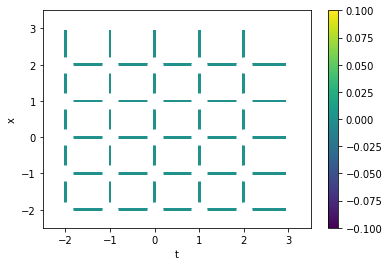

In [7]:
fig, ax = plt.subplots(1,1)
start = {}
start['m'] = L.form(1)
current = W.step(start)
L.plot_form(1,current['m'],ax)
fig.colorbar(ax.get_children()[0])

In [8]:
L.count_loops(current['m'])

0

In [9]:
current['m']

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [10]:
current

{'m': array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])}

In [11]:
loop_example= L.form(1)
loop_example[0,0,4]=1
loop_example[1,0,4]=-1
loop_example[1,1,4]=1
loop_example[0,0,0]=-1

loop_example[0,0,1]=1
loop_example[1,0,1]=-1
loop_example[1,1,1]=1
loop_example[0,0,2]=-1


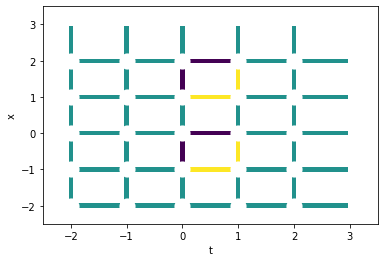

In [12]:
fig, ax = plt.subplots(1,1)
L.plot_form(1,loop_example,ax)

In [13]:
test = {}
test['m'] = loop_example
test['p'] = L.form(2)

In [17]:
# maplist = ['None','red','pink','blue','cyan','green','lime']
# maplist = ['None','red','orange','yellow','green','lime','blue']
maplist = []
def maxmag(N : np.array):
    return N.flat[np.abs(N).argmax()]  
def minmag(N : np.array):
    return N.flat[np.abs(N).argmax()]  
for i in range(len(maplist)//2):
    maplist.append([(1/len(maplist)*2)*(i+1)+0,0,0])
    maplist.insert(0,[0,0,1/len(maplist)*2*(i+1)])
for i in range(len(maplist)//2):
    maplist.append([0,(1/len(maplist)*2)*(i+1)+0,0])
    maplist.insert(0,[0,(1/len(maplist)*2)*(i+1)+0,(1/len(maplist)*2)*(i+1)+0])
print(len(maplist))
mycmap = colors.ListedColormap(maplist)
def plot_worms(cfg,fig = None,ax = None, norm = None ,cmap = None):
    if norm == None:
        norm = colors.Normalize(vmin = -np.max([1,np.abs(np.min(cfg)),np.abs(np.min(cfg))]), vmax = np.max([1,np.abs(np.min(cfg)),np.abs(np.min(cfg))]))
    if fig == None or ax == None:
        fig, ax = plt.subplots(1,1)
    links = [0,0] 
    links[0] = L.plot_form(1,cfg,ax,norm = norm,cmap = cmap, linkwidth = 0.04)
    links[1] = L.plot_form(2,L.d(1,cfg),ax,norm = norm,cmap = cmap)
    fig.colorbar(links[0])
    return links

0


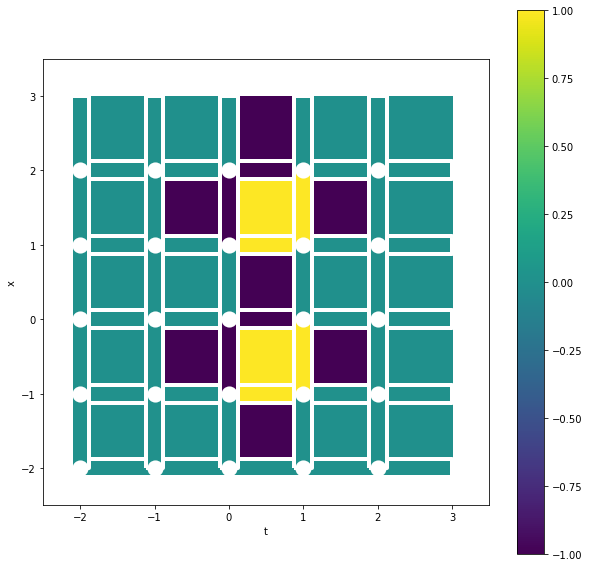

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
a = plot_worms(loop_example,fig,ax)

In [20]:
S.count_loops(loop_example)

2

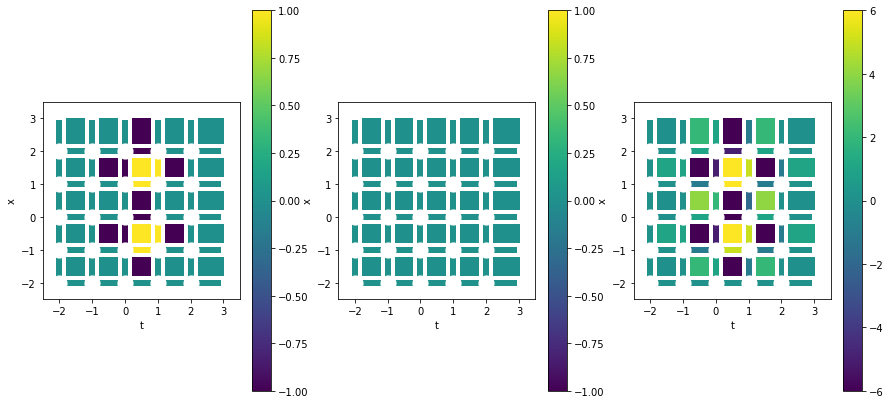

In [177]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
plot_worms(loop_example,fig,ax[0])
plot_worms(current['m'],fig,ax[1])
plot_worms(L.delta(2,L.d(1,loop_example)),fig,ax[2])

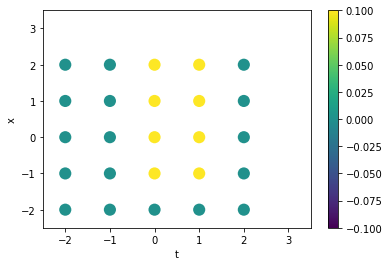

In [178]:
fig, ax = plt.subplots(1,1)
test = loop_example.copy()
test = np.abs(test)
q = 1
ledger = L.form(0)
for i in range(L.dims[0]):
    for j in range(L.dims[1]):
        if (np.array([test[0,i,j],test[1,i,j],test[0,i-1,j],test[1,i,j-1]])>0).any():
            ledger[i,j]=q
            q+=1
L.plot_form(0,ledger,ax)
plt.colorbar(ax.get_children()[0])

In [179]:
def count_loops(cfg):
    cfgabs = np.abs(cfg)
    #Takes the absolute value of a configuration's links to determine where a worm perturbation is
    #This must be applied to a worm on a zero background field, (or just subtract out the background field from before the worm)
    
    #Here I am checking each site for whether it lies on the worm (has an adjacent non-zero link),
    #and if so then give it an integer value. This is basically just a unique identifier, so the integer value 
    #increments each time
    q = 1
    ledger = L.form(0)
    for i in range(L.dims[0]):
        for j in range(L.dims[1]):
            if (np.array([cfgabs[0,i,j],cfgabs[1,i,j],cfgabs[0,i-1,j],cfgabs[1,i,j-1]])>0).any():
                ledger[i,j]=q
                q+=1

    oldledger = np.empty_like(ledger)
    while (ledger != oldledger).any():  #As long as we are not in a steady state
        oldledger = ledger.copy()
        for i in range(ledger.shape[0]):
            for j in range(ledger.shape[1]):
                if ledger[i,j] != 0:
                    for adj in [1,2,3,4]:   #Sift through each non-zero point in the ledger and its 
                        #adjacent links
                        #[1,2,3,4] -> [East,N,W,S]
                        if adj == 1:
                            test_link = cfgabs[0,i,j]
                            if test_link > 0:
                                #Here we check if the worm passes through a neighboring link, and if so we take
                                #the maximum of the two points connected by that link and adopt that for both
                                ledger[i,j] = max(ledger[i,j],ledger[L.mod([i+1,j])[0],L.mod([i+1,j])[1]])
                                ledger[L.mod([i+1,j])[0],L.mod([i+1,j])[1]] = ledger[i,j]
                        if adj == 2:
                            test_link = cfgabs[1,i,j]
                            if test_link > 0:
                                ledger[i,j] = max(ledger[i,j],ledger[L.mod([i,j+1])[0],L.mod([i,j+1])[1]])
                                ledger[L.mod([i,j+1])[0],L.mod([i,j+1])[1]] = ledger[i,j]
                        if adj == 3:
                            test_link = cfgabs[0,i-1,j]
                            if test_link > 0:
                                ledger[i,j] = max(ledger[i,j],ledger[L.mod([i-1,j])[0],L.mod([i-1,j])[1]])
                                ledger[L.mod([i-1,j])[0],L.mod([i-1,j])[1]] = ledger[i,j]
                        if adj == 4:
                            test_link = cfgabs[1,i,j-1]
                            if test_link > 0:
                                ledger[i,j] = max(ledger[i,j],ledger[L.mod([i,j-1])[0],L.mod([i,j-1])[1]])
                                ledger[L.mod([i,j-1])[0],L.mod([i,j-1])[1]] = ledger[i,j]
    #Once the process reaches a steady state, ie. the maximums in all connected loops have proliferated
    #we can just count the number of unique maximums that we obtain (other than 0)
    return np.sum(np.unique(ledger) > 0)

In [180]:
np.sum(np.unique(ledger) > 0)

8

In [181]:
count_loops(w.configurations.fields['m'][-3])

1

## Single step proof of concept

In [ ]:
fig, ax = plt.subplots(1,1)
startpoint = np.array([0,0])
endpoint = startpoint + np.array([1,1])
currentpoint = startpoint.copy()
configlist = []
propositions=0
currentconfig = L.form(1)
initconfig = currentconfig.copy()
length = 0
probslist = []
while (endpoint != startpoint).any():
    newconfig, endpoint, probs = W.burrow(currentconfig, currentpoint)
    currentpoint = endpoint.copy()
    currentconfig = newconfig.copy()
    configlist.append(currentconfig)
    propositions += 1
length = np.sum(np.abs(currentconfig-initconfig))
print(f'Propositions: {propositions}')
print(f'Length: {length}')
L.plot_form(1,currentconfig,ax)
fig.colorbar(ax.get_children()[0], ax=ax, orientation='horizontal')

In [ ]:
ax.get_children()

In [ ]:
S.valid(newconfig)

In [ ]:
newconfig

In [ ]:
probs

# Ensemble generation
Currently stalls, and so I have it throw an error if a worm reaches 1000 propositions

In [ ]:
L = sv.lattice.Lattice2D(5)
S = sv.action.Worldline(L,0.5)
W = sv.generator.worm.UndirectedWorm(S,1)
ensemble = sv.ensemble.Ensemble(S)
ensemble = ensemble.generate(1000,W,progress = tqdm)

Here we plot the change in the last 50 configurations top to bottom to show the stalling behavior of the worm. Beware colors in plotting can behave strangely if the range is restricted

In [ ]:
len(W.startpointlist)

In [ ]:
fig, ax = plt.subplots(1,1)
W.startpointlist
blank = L.form(0)
for point in W.startpointlist:
    blank[point[0],point[1]]+=1
L.plot_form(0,blank,ax)
fig.colorbar(ax.get_children()[0], ax=ax, orientation='horizontal')
    # blank[point[0],point[1]] = 1


In [ ]:
W.endconfiglist

In [ ]:
fig,ax = plt.subplots(1,1)
configs = W.endconfiglist
j = 16
colors
L.plot_form(1,configs[j],ax,label = 'links',linkwidth = .05)

In [ ]:
np.mean(sv.analysis.Bootstrap(ensemble).InternalEnergyDensity)

In [ ]:
ensemblePlaq = sv.ens

In [ ]:
W.avg_length

In [ ]:
x = [1,2,3,4,5]
y = [5,4,3,9,10]
plt.scatter(x,y,c = y, norm = None)

In [ ]:
norm = colors.CenteredNorm()
plot = L.form(0)
plot[0,0]=1
fig,ax = plt.subplots(1,1)
L.plot_form(0,plot,ax, norm = norm)

In [ ]:
counter = L.form(0)
j = -400
a = np.array(W.lastsiteslist[j:j+50])
for el in a:
    counter[el[0],el[1]] +=1
fig, ax = plt.subplots(1,1)
L.plot_form(0,counter,ax)
fig.colorbar(ax.get_children()[0])

In [ ]:
W.lastconfigslist[-400]
L.delta(1,W.lastconfigslist[-400])

In [ ]:
W.lastconfigslist[-1]

In [ ]:
counter

In [ ]:
print(ct)

In [ ]:
np.unique(W.lastsiteslist[:-50])

In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(1,W.lastconfigslist[991]-W.endconfiglist[-1],ax)

In [ ]:
W.lastconfigslist[2]-W.endconfiglist[-1]

In [ ]:
W.lastconfigslist[0]


In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(0,W.startpointlist[-1],ax)

In [ ]:
fig, ax = plt.subplots(50,1, figsize = (50,300))
for j in range(50):
    config = W.lastconfigslist[-50+j]
    sites = W.lastsiteslist[-50+j]
    siteconfig = L.form(0)
    siteconfig[sites[0],sites[1]] += 1
    L.plot_form(1,config - W.lastconfigslist[-50+j-1],ax[j])
    L.plot_form(0,siteconfig,ax[j])
    ax[j].set_title(W.lastprobslist[-50+j])
fig.colorbar(ax[0].get_children()[1], ax=ax, orientation='horizontal')


# DEPRECATED:
Code I used to manually run propositions for the worm

In [ ]:
config2, end2, probs2 = W.burrow(L.plot_form(0),[0,0])
fig, ax = plt.subplots(1,1)
L.plot_form(1,config2,ax)
center = L.form(0)
center[0,0] = 1
center[end2[0],end2[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (10,20))
L.plot_form(1,L.form(1),ax[0])
L.plot_form(0,L.form(0),ax[0])
newconfig = W.step({'m':L.form(1)})
L.plot_form(1,newconfig['m'],ax[1])
L.plot_form(0,L.form(0),ax[1])

In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(1,newconfig['m'],ax)


In [ ]:
config3, end3, probs3 = W.burrow(config2,end2)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config3,ax)
center = L.form(0)
center[0,0] = 1
center[end3[0],end3[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
config4, end4, probs4 = W.burrow(config3,end3)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config4,ax)
center = L.form(0)
center[0,0] = 1
center[end4[0],end4[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
config5, end5, probs5 = W.burrow(config4,end4)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config5,ax)
center = L.form(0)
center[0,0] = 1
center[end5[0],end5[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
print(probs2,sum(probs2))
print(probs3,sum(probs3))
print(probs4,sum(probs4))
print(probs5,sum(probs5))